#**TRABALHO NLP UNINTER - 2024**

Com a proliferação crescente de desinformação através das redes sociais, torna-se imprescindível o desenvolvimento de ferramentas automáticas para verificar a autenticidade dessas informações. Avaliar a veracidade de uma notícia é uma tarefa desafiadora, mesmo para profissionais experientes em jornalismo e linguística. Portanto, uma solução automatizada seria de grande valia para a sociedade. Diante dessa necessidade, concebemos esta atividade com o intuito de permitir que você aplique e aprimore os conhecimentos adquiridos em aulas teóricas e práticas, enquanto contribui para um projeto real de relevância pública.
Utilizamos o corpus FakeBr (disponível em https://github.com/roneysco/Fake.br-Corpus), que consiste em 7200 instâncias, cada uma com 28 atributos e um rótulo. Esse corpus está categorizado de forma binária, sendo os textos falsos classificados como "FAKE" (3600 entradas) e os verdadeiros como "REAL" (3600 entradas).
Abaixo segue o código referente à atividade prática. Desde já, agradeço pela atenção dedicada à revisão da apresentação.

#INSTALAR BIBLIOTECAS E DEPENDÊNCIAS NECESSÁRIAS

In [1]:
!pip install notebook wordcloud pillow numpy bs4 tqdm gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00


In [2]:
import git
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import PIL.Image

**IMPORTANDO ARQUIVOS DO REPOSITÓRIO FAKE.BR ATRAVÉS DE UMA FUNÇÃO**

In [3]:
#importar arquivo do repositorio
def clone_github_repository(owner, repo, destination_path):
    repository_url = f"https://github.com/{owner}/{repo}.git"

    try:
        git.Repo.clone_from(repository_url, destination_path)
        print(f"Repositório clonado com sucesso em {destination_path}")
    except Exception as e:
        print(f"Falha ao clonar o repositório: {e}")

# Substitua 'roneysco' e 'Fake.br-Corpus' como os valores reais do proprietário e repositório
clone_github_repository(owner='roneysco', repo='Fake.br-Corpus', destination_path='./Fake.br-Corpus')

Repositório clonado com sucesso em ./Fake.br-Corpus


**IMPORTANDO ARQUIVOS CSV COM AS INFORMAÇÕES DE COLUNAS PRÉ-SELECIONADAS**

In [5]:
#importa arquivo csv com as informações de colunas selecionadas
# caminho'/content/Fake.br-Corpus/preprocessed/pre-processed.csv' arquivo CSV
ru_3799879 = '/content/Fake.br-Corpus/preprocessed/pre-processed.csv'

# encoding='utf-8' para lidar com caracteres acentuados
# Se houver problemas, tente utilizar encoding='latin1' ou encoding='ISO-8859-1'

df_colunas = ['label', 'preprocessed_news']
df = pd.read_csv(ru_3799879, encoding='utf-8', usecols=df_colunas, low_memory = False)

#Visualizando as 10 primeiras linhas do DataFrame
df.head(10)

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...
5,fake,willian waack continuara internado sirio liban...
6,fake,problema cardiaco tira william waack jornal gl...
7,fake,edir macedo podera disputar eleicoes presidenc...
8,fake,boechat sobre lula alma pode ser honesta gover...
9,fake,pt diz lula nao dinheiro sobreviver chama moro...


In [6]:
# quantidade de instâncias
len(df)

7200

In [7]:
# coluna chamada 'label'
contagem_rotulos = df['label'].value_counts()

# Exibindo a contagem de cada rótulo
print(contagem_rotulos)

fake    3600
true    3600
Name: label, dtype: int64


In [8]:
# coluna que contém as notícias pré-processadas
coluna_noticias = 'preprocessed_news'

# variável para armazenar a contagem total de palavras
total_palavras = 0

# Itere sobre as linhas do DataFrame
for indice, linha in df.iterrows():
    # string da coluna 'preprocessed_news'
    noticia = linha[coluna_noticias]

    # Dividir a string em palavras
    palavras = noticia.split()

    # contagem de palavras da linha ao total
    total_palavras += len(palavras)

# Exiba o total de palavras
print("Total de palavras no corpus:", total_palavras)

Total de palavras no corpus: 2638355


In [9]:
# Dividindo os dados em conjuntos de treinamento e teste
df_treino, df_teste = train_test_split(df, test_size=0.25, random_state=42)

In [10]:
# DataFrame com coluna 'preprocessed_news'
coluna_noticias = 'preprocessed_news'

# Criar um objeto TF-IDF Vectorizer com bigramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Aplicar o TF-IDF ao conjunto de treinamento
X_tfidf = tfidf_vectorizer.fit_transform(df_treino[coluna_noticias])

# Obter as estatísticas desejadas (por exemplo, as top N palavras)
# Neste exemplo, estamos usando SelectKBest para selecionar as top 50 palavras, 10% do total mostrado nas wordclouds (fake e true)
k_best = SelectKBest(f_classif, k=50)
X_tfidf_top = k_best.fit_transform(X_tfidf, df_treino['label'])

# Exibir as top 10 palavras
feature_names = tfidf_vectorizer.get_feature_names_out()
top_feature_indices = k_best.get_support(indices=True)
top_features = [feature_names[i] for i in top_feature_indices]

print("Top 50 palavras usando TF-IDF e bigramas:")
print(top_features)

Top 50 palavras usando TF-IDF e bigramas:
['afirma', 'afirmou', 'ainda', 'alem', 'ano', 'ano passado', 'anos', 'antes', 'apesar', 'apos', 'ate', 'caso', 'decisao', 'desde', 'desta', 'dia', 'disso', 'diz', 'dois', 'entanto', 'entao', 'exemplo', 'federal', 'forma', 'ha', 'ja', 'justica', 'meio', 'ministerio', 'nao', 'nesta', 'outras', 'outro', 'outros', 'passado', 'porque', 'primeira', 'primeiro', 'processo', 'regiao', 'relacao', 'sao', 'segundo', 'ser', 'sido', 'sobre', 'tambem', 'ter', 'tres', 'tribunal']


**TREINAR O MODELO**

In [11]:
# Separar as features (X) e os rótulos (y) do conjunto de treinamento
X_treino = df_treino[coluna_noticias]
y_treino = df_treino['label']

# Separar as features (X) e os rótulos (y) do conjunto de teste
X_teste = df_teste[coluna_noticias]
y_teste = df_teste['label']

modelo = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('classificador', SVC())
])

# Treinar o modelo
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
previsoes = modelo.predict(X_teste)

# Avaliar a acurácia
acuracia = accuracy_score(y_teste, previsoes)

print("Acurácia do modelo:", acuracia)

# Exibir o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_teste, previsoes))

Acurácia do modelo: 0.9377777777777778

Relatório de Classificação:
              precision    recall  f1-score   support

        fake       0.98      0.90      0.94       915
        true       0.90      0.98      0.94       885

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



**Separar os dados rotulados como TRUE**

In [13]:
# Separar os dados rotulados como TRUE
df_real = df[df['label'] == 'true']

# Separar os dados em conjunto de treinamento e teste
df_real_treino, df_real_teste = train_test_split(df_real, test_size=0.25, random_state=42)

# Separar as features (X) e os rótulos (y) do conjunto de treinamento e teste
X_real_treino = df_real_treino[coluna_noticias]
y_real_treino = df_real_treino['label']

X_real_teste = df_real_teste[coluna_noticias]
y_real_teste = df_real_teste['label']

# Criar um modelo de classificação usando Multinomial Naive Bayes
modelo_real = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),  # Altere o ngram_range conforme necessário
    ('classificador', MultinomialNB())
])

# Treinar o modelo
modelo_real.fit(X_real_treino, y_real_treino)

# Fazer previsões no conjunto de teste
previsoes_real = modelo_real.predict(X_real_teste)

# Avaliar a acurácia do modelo
acuracia_real = accuracy_score(y_real_teste, previsoes_real)

# Obter as features (palavras, bigramas, trigramas)
features = modelo_real.named_steps['vectorizer'].get_feature_names_out()

# Exibir a quantidade de palavras, bigramas e trigramas
quantidade_palavras = sum(' ' not in feature for feature in features)
quantidade_bigramas = sum(' ' in feature for feature in features)
quantidade_trigramas = sum(feature.count(' ') == 2 for feature in features)

print("Quantidade de palavras usadas:", quantidade_palavras)
print("Quantidade de bigramas usados:", quantidade_bigramas)
print("Quantidade de trigramas usados:", quantidade_trigramas)
print("Acurácia do modelo para textos rotulados como TRUE:", acuracia_real)

Quantidade de palavras usadas: 65816
Quantidade de bigramas usados: 2496262
Quantidade de trigramas usados: 1465374
Acurácia do modelo para textos rotulados como TRUE: 1.0


**Separar os dados rotulados como FAKE**

In [14]:
# Separar os dados rotulados como FAKE
df_real = df[df['label'] == 'fake']

# Separar os dados em conjunto de treinamento e teste
df_real_treino, df_real_teste = train_test_split(df_real, test_size=0.25, random_state=42)

# Separar as features (X) e os rótulos (y) do conjunto de treinamento e teste
X_real_treino = df_real_treino[coluna_noticias]
y_real_treino = df_real_treino['label']

X_real_teste = df_real_teste[coluna_noticias]
y_real_teste = df_real_teste['label']

# Criar um modelo de classificação usando Multinomial Naive Bayes
modelo_real = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),  # Altere o ngram_range conforme necessário
    ('classificador', MultinomialNB())
])

# Treinar o modelo
modelo_real.fit(X_real_treino, y_real_treino)

# Fazer previsões no conjunto de teste
previsoes_real = modelo_real.predict(X_real_teste)

# Avaliar a acurácia do modelo
acuracia_real = accuracy_score(y_real_teste, previsoes_real)

# Obter as features (palavras, bigramas, trigramas)
features = modelo_real.named_steps['vectorizer'].get_feature_names_out()

# Exibir a quantidade de palavras, bigramas e trigramas
quantidade_palavras = sum(' ' not in feature for feature in features)
quantidade_bigramas = sum(' ' in feature for feature in features)
quantidade_trigramas = sum(feature.count(' ') == 2 for feature in features)

print("Quantidade de palavras usadas:", quantidade_palavras)
print("Quantidade de bigramas usados:", quantidade_bigramas)
print("Quantidade de trigramas usados:", quantidade_trigramas)
print("Acurácia do modelo para textos rotulados como FAKE:", acuracia_real)

Quantidade de palavras usadas: 27967
Quantidade de bigramas usados: 483629
Quantidade de trigramas usados: 268475
Acurácia do modelo para textos rotulados como FAKE: 1.0


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
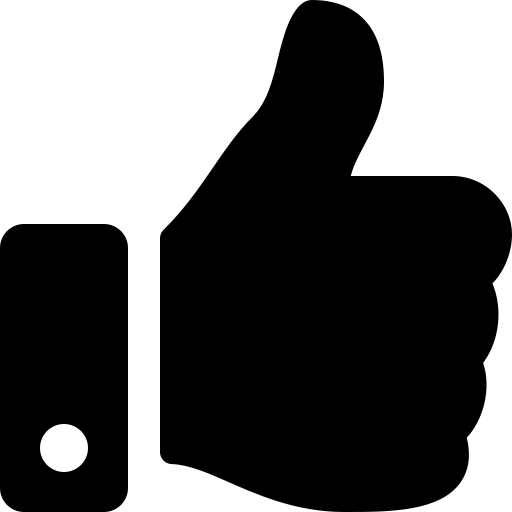

In [31]:
#importar máscara da imagem de fundo TRUE
imagem_mascara = np.array(PIL.Image.open("/content/positivo.png"))

imagem_mascara

In [32]:
# Adicione as previsões ao DataFrame de teste
df_teste['previsoes'] = previsoes

# Separe os textos por classe
text_real = ' '.join(df_teste[df_teste['previsoes'] == 'true'][coluna_noticias])

wordcloud = WordCloud(background_color='white',
                      max_words=500,
                      mask=imagem_mascara,
                      contour_color="grey",
                      contour_width=0.3,
                      min_font_size=3,
                      random_state=42).generate(text_real)

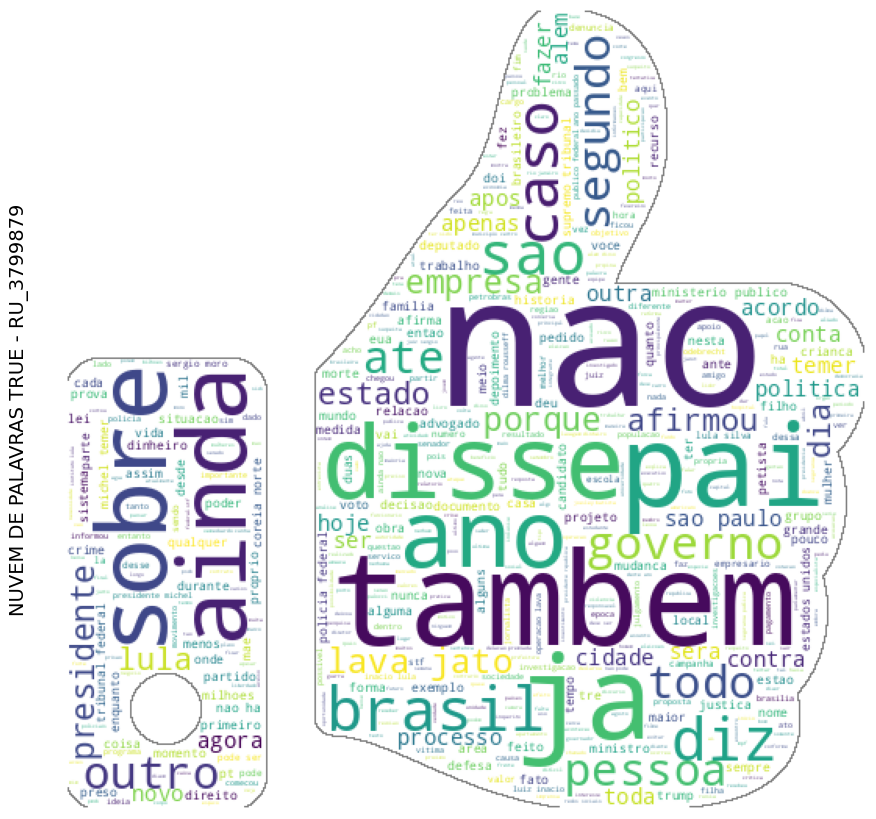

In [33]:
# Mostrando a imagem
def gerar_wordcloud(texto, titulo):
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)

  #plt.title(titulo)

#remove os eixos do gráfico
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.text(-0.07, 0.5, titulo, transform=plt.gca().transAxes, rotation=90, va='center', ha='left', fontsize=14)
  plt.show()

# Gerar nuvem de palavras para TRUE
gerar_wordcloud(text_real, 'NUVEM DE PALAVRAS TRUE - RU_3799879')

In [34]:
#gravar imagem no caminho /content/wordCloudTrue.png
wordcloud.to_file('/content/wordCloudTrue.png')

In [36]:
#importar máscara da imagem de fundo FAKE
imagem_mascara = np.array(PIL.Image.open("/content/negativo.png"))

imagem_mascara

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [37]:
# Adicione as previsões ao DataFrame de teste
df_teste['previsoes'] = previsoes

# Separe os textos por classe
text_fake = ' '.join(df_teste[df_teste['previsoes'] == 'fake'][coluna_noticias])

wordcloud = WordCloud(background_color='white',
                      max_words=500,
                      mask=imagem_mascara,
                      contour_color="grey",
                      contour_width=0.3,
                      min_font_size=3,
                      random_state=42).generate(text_fake)

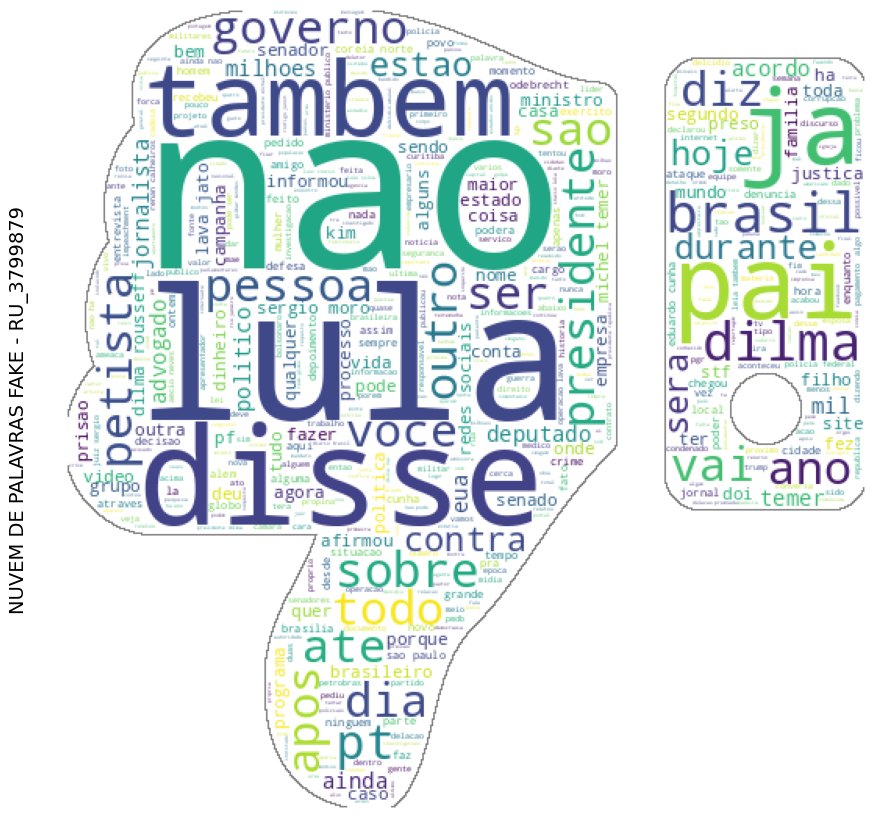

In [38]:
# Mostrando a imagem
def gerar_wordcloud(texto, titulo):
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)

  #plt.title(titulo)

#remove os eixos do gráfico
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.text(-0.07, 0.5, titulo, transform=plt.gca().transAxes, rotation=90, va='center', ha='left', fontsize=14)
  plt.show()

# Gerar nuvem de palavras para FAKE
gerar_wordcloud(text_fake, 'NUVEM DE PALAVRAS FAKE - RU_3799879')

In [25]:
#gravar imagem no caminho /content/wordCloudFake.png
wordcloud.to_file('/content/wordCloudFake.png')